In [1]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt

In [2]:
cols = ['ra', 'dec', 'id_galaxy_sky', 'id_group_sky', 'type', 'zcos', 'zobs', 'mstars_bulge', 'mstars_disk', 'mgas_disk', 'mgas_bulge', 'mvir_hosthalo', 'mvir_subhalo', 'id_fof', 'sfr_disk', 'sfr_burst', 'total_ab_dust_u_VST', 'total_ab_dust_g_VST', 'total_ab_dust_r_VST', 'total_ab_dust_i_VST', 'total_ab_dust_Z_VISTA', 'total_ab_dust_Y_VISTA', 'total_ab_dust_J_VISTA', 'total_ab_dust_H_VISTA', 'total_ab_dust_K_VISTA']

In [3]:
# Loading in sharks wave wide
groups_path = '/Users/sp624AA/Downloads/mocks/v0.4.0/waves_deep_groups.parquet'
gals_path = '/Users/sp624AA/Downloads/mocks/v0.4.0/waves_deep_gals.parquet'

groups = pd.read_parquet(groups_path)
gals = pd.read_parquet(gals_path, columns = cols)


In [4]:
# Filer for valid stellar mass
gals['log_stellar_mass'] = np.log10((gals['mstars_disk'] + gals['mstars_bulge'])/0.67)
gals['log_sfr_total'] = np.log10((gals['sfr_disk'] + gals['sfr_burst']) * 1e-9/0.67 + 1e-20)
gals['log_sSFR'] = np.log10((gals['sfr_disk'] * 1e-9 + gals['sfr_burst'] * 1e-9) / (gals['mstars_disk'] + gals['mstars_bulge']) / 0.67 + 1e-20)
mask = (gals['log_stellar_mass'] > 8) & (gals['total_ab_dust_Z_VISTA'] > -99)
gals = gals[mask].reset_index(drop=True)


In [5]:
gals['id_fof'].unique()


array([     -1,       8,       9, ..., 5121163, 5121192, 5123023],
      shape=(47036,))

In [8]:
group_col = "id_fof"
mag_col   = "total_ab_dust_r_VST"   # absolute r-band magnitude (lower = brighter)
mass_col  = "mvir_hosthalo"

# Optional but strongly recommended: set this if you have a host-halo identifier.
# If None, we fall back to de-duping by rounded mass values (less reliable).
host_id_col = None  # e.g. "host_halo_id"

# -----------------------------
# 1) BCG assignment
#   - id_fof == -1 : by default BCG
#   - otherwise: brightest (min Mr) per FoF group
# -----------------------------
gals["is_bcg"] = False

ungrouped = gals[group_col] == -1
gals.loc[ungrouped, "is_bcg"] = True

valid_grouped = (
    gals[group_col].notna()
    & (gals[group_col] != -1)
    & gals[mag_col].notna()
)

# Pick brightest in r-band: minimum absolute magnitude
bcg_idx = gals.loc[valid_grouped].groupby(group_col)[mag_col].idxmin()
gals.loc[bcg_idx, "is_bcg"] = True

print(gals["is_bcg"].value_counts())

# -----------------------------
# 2) Broadcast BCG properties
#   - For grouped galaxies: copy from the group BCG
#   - For id_fof == -1: keep self values (each is its own BCG)
# -----------------------------
for col in ["ra", "dec", "zobs", mag_col]:
    gals[f"{col}_bcg"] = gals[col]  # default: self (covers id_fof == -1 nicely)

# Build mapping ONLY for real groups (unique by construction)
bcg_rows = gals.loc[gals["is_bcg"] & ~ungrouped, [group_col, "ra", "dec", "zobs", mag_col]]

ra_map   = bcg_rows.set_index(group_col)["ra"]
dec_map  = bcg_rows.set_index(group_col)["dec"]
zobs_map = bcg_rows.set_index(group_col)["zobs"]
mag_map  = bcg_rows.set_index(group_col)[mag_col]

grouped = ~ungrouped & gals[group_col].notna()
gals.loc[grouped, "ra_bcg"]   = gals.loc[grouped, group_col].map(ra_map)
gals.loc[grouped, "dec_bcg"]  = gals.loc[grouped, group_col].map(dec_map)
gals.loc[grouped, "zobs_bcg"] = gals.loc[grouped, group_col].map(zobs_map)
gals.loc[grouped, f"{mag_col}_bcg"] = gals.loc[grouped, group_col].map(mag_map)

# -----------------------------
# 3) FoF halo mass = sum of UNIQUE host halos within each FoF
#   - Only for id_fof != -1
#   - For id_fof == -1: per-galaxy default (no aggregation across all -1 rows)
# -----------------------------
gals["fof_halo_mass"] = np.nan

grouped = gals[group_col].notna() & (gals[group_col] != -1)
ungrouped = gals[group_col] == -1

if host_id_col is not None and host_id_col in gals.columns:
    # sum one host mass per unique host halo ID within each FoF group
    fof_mass = (
        gals.loc[grouped]
            .dropna(subset=[group_col, host_id_col, mass_col])
            .drop_duplicates(subset=[group_col, host_id_col])
            .groupby(group_col)[mass_col]
            .sum()
    )
else:
    # fallback: dedupe by rounded mass value (less reliable than an ID)
    tmp = gals.loc[grouped, [group_col, mass_col]].copy()
    tmp["mass_rounded"] = tmp[mass_col].round(6)

    fof_mass = (
        tmp.dropna(subset=[group_col, "mass_rounded"])
           .drop_duplicates(subset=[group_col, "mass_rounded"])
           .groupby(group_col)[mass_col]
           .sum()
    )

gals.loc[grouped, "fof_halo_mass"] = gals.loc[grouped, group_col].map(fof_mass)

# For id_fof == -1, treat each galaxy as its own "FoF": use its own host mass
gals.loc[ungrouped, "fof_halo_mass"] = gals.loc[ungrouped, mass_col]

gals["log_fof_halo_mass"] = np.log10(gals["fof_halo_mass"].where(gals["fof_halo_mass"] > 0))

is_bcg
True     472135
False    104863
Name: count, dtype: int64


(array([2.0000e+00, 8.0000e+00, 4.8000e+01, 3.1100e+02, 7.0600e+02,
        1.2260e+03, 1.8750e+03, 2.5510e+03, 3.2200e+03, 3.8850e+03,
        4.9280e+03, 7.2550e+03, 1.1915e+04, 1.9285e+04, 2.9024e+04,
        3.8055e+04, 4.2802e+04, 4.4238e+04, 4.1944e+04, 3.7823e+04,
        3.3032e+04, 2.8114e+04, 2.3746e+04, 1.9716e+04, 1.6777e+04,
        1.3951e+04, 1.2617e+04, 1.2540e+04, 1.3742e+04, 1.6351e+04,
        1.9256e+04, 1.9946e+04, 1.7672e+04, 1.3745e+04, 9.6490e+03,
        6.2340e+03, 3.7050e+03, 2.1760e+03, 1.2080e+03, 7.3400e+02,
        4.4000e+02, 2.3900e+02, 1.4400e+02, 8.2000e+01, 3.9000e+01,
        2.7000e+01, 8.0000e+00, 5.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.09534264, -0.07051574, -0.04568886, -0.02086197,  0.00396492,
         0.02879182,  0.0536187 ,  0.0784456 ,  0.10327248,  0.12809937,
         0.15292627,  0.17775315,  0.20258003,  0.22740692,  0.25223383,
         0.27706072,  0.3018876 ,  0.32671449,  0.35154137,  0.37636828,
         0.40119517,  0.42

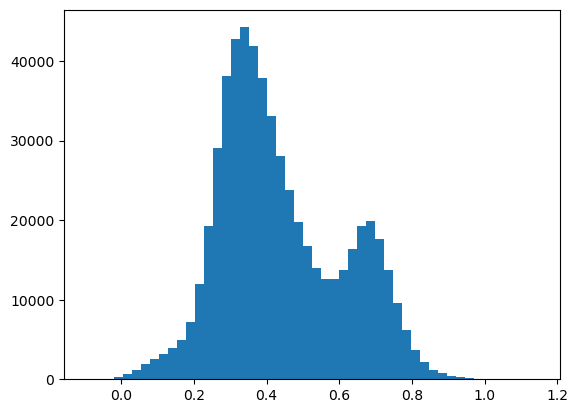

In [9]:
# g-r plot
plt.hist(gals['total_ab_dust_g_VST'] - gals['total_ab_dust_r_VST'], bins=50)

(array([2.41300e+03, 2.60000e+01, 1.30000e+01, 2.50000e+01, 1.50000e+01,
        1.80000e+01, 9.00000e+00, 1.10000e+01, 7.00000e+00, 5.00000e+00,
        2.30000e+01, 1.10000e+01, 3.30000e+01, 5.00000e+01, 6.30000e+01,
        1.28000e+02, 2.54000e+02, 4.16000e+02, 6.17000e+02, 9.06000e+02,
        1.18500e+03, 1.76900e+03, 2.47500e+03, 3.29600e+03, 4.35500e+03,
        5.18800e+03, 6.32700e+03, 7.56700e+03, 8.76300e+03, 1.03270e+04,
        1.20350e+04, 1.48280e+04, 1.85380e+04, 2.28070e+04, 2.52470e+04,
        3.60990e+04, 1.09223e+05, 1.79097e+05, 6.76090e+04, 1.44700e+04,
        9.17400e+03, 7.35600e+03, 3.92500e+03, 2.93000e+02, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-20.        , -19.71879387, -19.43758583, -19.1563797 ,
        -18.87517357, -18.59396553, -18.3127594 , -18.03155136,
        -17.75034523, -17.4691391 , -17.18793106, -16.90672493,
        -16.6255188 , -16.34431076, -16.06310463, -15.78189754,
        -15.

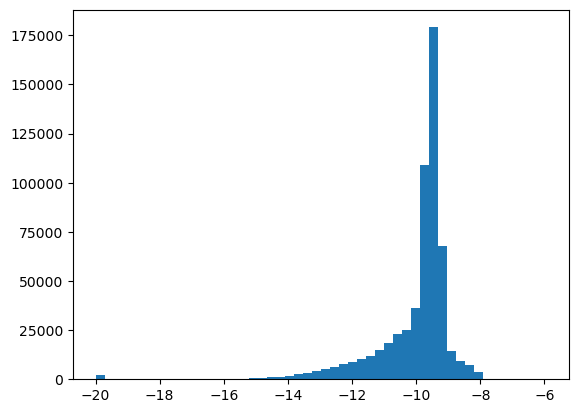

In [10]:
# sfr hist
plt.hist(gals['log_sSFR'], bins=50)

(-16.0, -8.0)

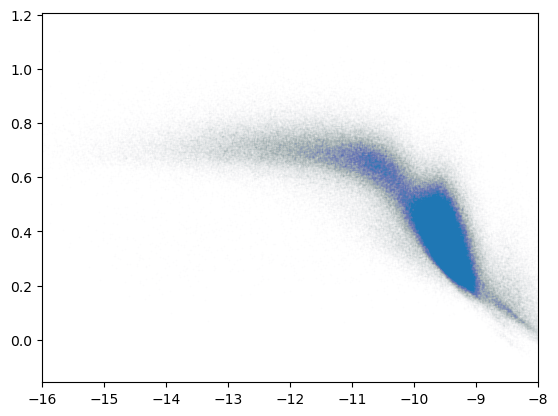

In [11]:
# plot g - r vs ssfr/stellarmass
plt.scatter(gals['log_sSFR'],gals['total_ab_dust_g_VST'] - gals['total_ab_dust_r_VST'], s=0.2, alpha=0.01)
plt.xlim(-16, -8)

In [12]:
# From SDSS and Tinker, we take cut to be at log_sSFR = -11
gals['is_red'] = gals['log_sSFR'] < -11

In [13]:
gals.columns

Index(['ra', 'dec', 'id_galaxy_sky', 'id_group_sky', 'type', 'zcos', 'zobs',
       'mstars_bulge', 'mstars_disk', 'mgas_disk', 'mgas_bulge',
       'mvir_hosthalo', 'mvir_subhalo', 'id_fof', 'sfr_disk', 'sfr_burst',
       'total_ab_dust_u_VST', 'total_ab_dust_g_VST', 'total_ab_dust_r_VST',
       'total_ab_dust_i_VST', 'total_ab_dust_Z_VISTA', 'total_ab_dust_Y_VISTA',
       'total_ab_dust_J_VISTA', 'total_ab_dust_H_VISTA',
       'total_ab_dust_K_VISTA', 'log_stellar_mass', 'log_sfr_total',
       'log_sSFR', 'is_bcg', 'ra_bcg', 'dec_bcg', 'zobs_bcg',
       'total_ab_dust_r_VST_bcg', 'fof_halo_mass', 'log_fof_halo_mass',
       'is_red'],
      dtype='object')

In [14]:
import sys
from pathlib import Path

sys.path.append("/Users/sp624AA/Code/halofinder")

from src.halo_p_M_funcs import find_p_M

In [15]:
gals['Bs'] = np.full(len(gals), 0)
gals['Bs'] = gals.apply(lambda row: find_p_M(row['ra_bcg'], row['dec_bcg'], row['ra'], row['dec'], row['zobs_bcg'], row['zobs'], row['fof_halo_mass'], omega_matter=0.3, h=0.67) if not row['is_bcg'] else np.inf, axis=1)


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   11.,  159.,  407.,  700., 1194., 1839., 2534.,
        3053., 3580., 4088., 4117., 4005., 3858., 3737., 3554., 3191.,
        3061., 2689., 2470., 2202., 1907., 1709., 1463., 1292., 1149.,
        1005.,  923.,  738.,  634.,  550.,  487.,  434.,  315.,  294.,
         247.,  213.,  170.,  156.,  127.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 artists>)

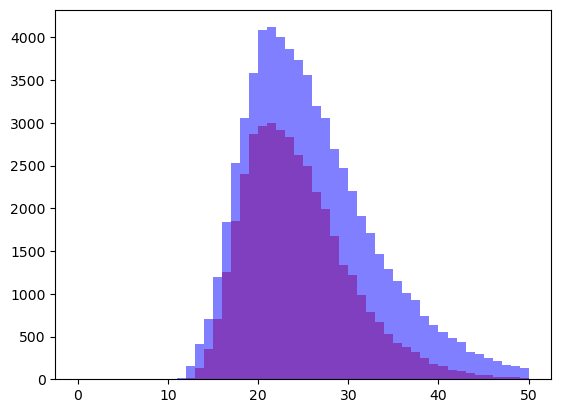

In [16]:
# plot Bs histogram by is_red
# halo mass is called 'fof_halo_mass'
gals['is_red'] = gals['log_sSFR'] < -11
red_gals = gals[gals['is_red']]
blue_gals = gals[~gals['is_red']]
plt.hist(red_gals['Bs'], bins = 50, range = [0, 50], alpha=0.5, label='Red Galaxies', color='r')
plt.hist(blue_gals['Bs'], bins = 50, range = [0, 50], alpha=0.5, label='Blue Galaxies', color='b')

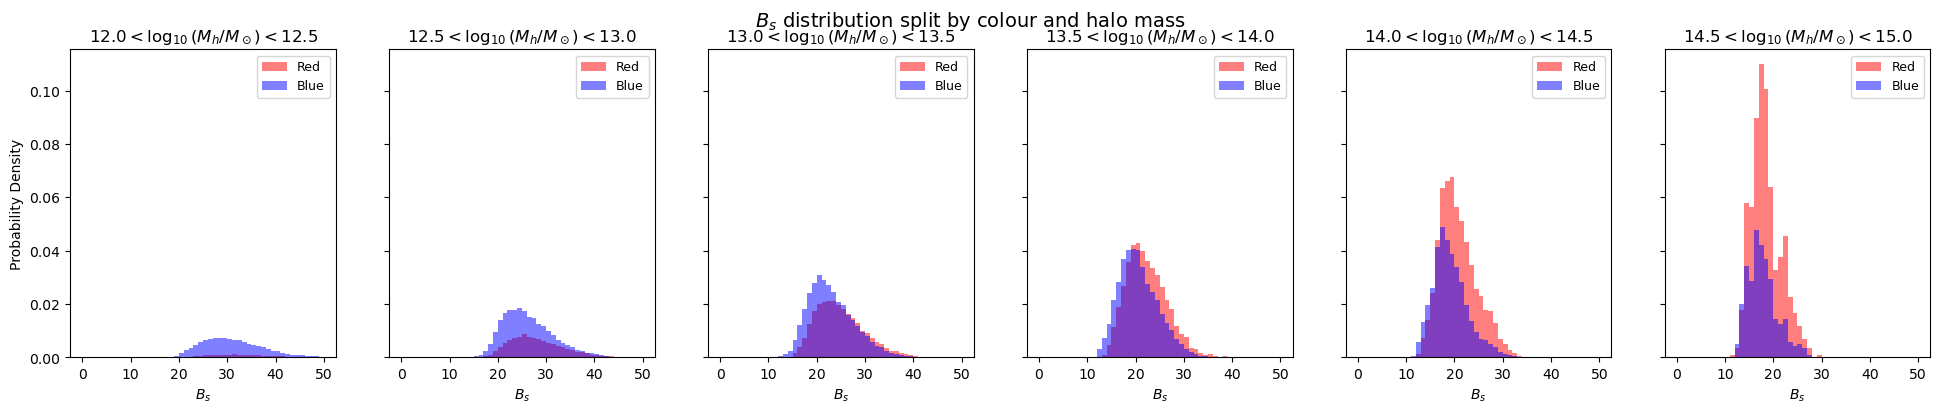

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define red / blue split
gals["is_red"] = gals["log_sSFR"] < -11
red_gals = gals[gals["is_red"]]
blue_gals = gals[~gals["is_red"]]

# Halo mass bins: 11–15 in steps of 1
mh_bins = np.arange(12, 15.5, 0.5)

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(mh_bins) - 1,
    figsize=(4 * (len(mh_bins) - 1), 4),
    sharey=True,
)

for i, (mh_min, mh_max) in enumerate(zip(mh_bins[:-1], mh_bins[1:])):
    ax = axes[i]

    # Select halo-mass slice
    red_sel = red_gals[
        (red_gals["log_fof_halo_mass"] >= mh_min)
        & (red_gals["log_fof_halo_mass"] < mh_max)
    ]
    blue_sel = blue_gals[
        (blue_gals["log_fof_halo_mass"] >= mh_min)
        & (blue_gals["log_fof_halo_mass"] < mh_max)
    ]

        # Total counts in this halo-mass bin
    n_red = len(red_sel)
    n_blue = len(blue_sel)
    n_tot = n_red + n_blue

    # Skip empty bins safely
    if n_tot == 0:
        continue

    # Histograms normalised by total (red + blue)
    ax.hist(
        red_sel["Bs"],
        bins=50,
        range=(0, 50),
        weights=np.ones(n_red) / n_tot,
        alpha=0.5,
        label="Red",
        color="r",
    )

    ax.hist(
        blue_sel["Bs"],
        bins=50,
        range=(0, 50),
        weights=np.ones(n_blue) / n_tot,
        alpha=0.5,
        label="Blue",
        color="b",
    )

    ax.set_title(rf"$ {mh_min} < \log_{{10}}(M_h/M_\odot) < {mh_max} $")
    ax.set_xlabel(r"$B_s$")

    if i == 0:
        ax.set_ylabel("Probability Density")

    ax.legend(frameon=True, fontsize=9)

fig.suptitle(
    r"$B_s$ distribution split by colour and halo mass",
    fontsize=14,
)

#plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


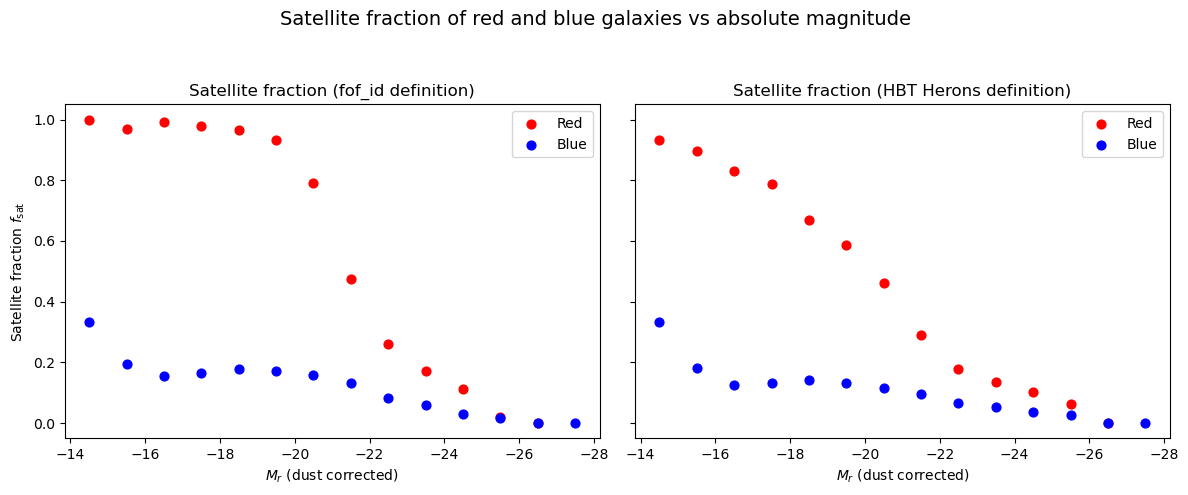

In [19]:

# -----------------------------
# Definitions
# -----------------------------
mag_col = "total_ab_dust_r_VST"

# magnitude bins (width = 1 mag)
mag_min = np.floor(gals[mag_col].min())
mag_max = np.ceil(gals[mag_col].max())
mag_bins = np.arange(mag_min, mag_max + 1, 1.0)
mag_centres = 0.5 * (mag_bins[:-1] + mag_bins[1:])

# -----------------------------
# Helper to compute f_sat
# -----------------------------
def satellite_fraction(gals_bin, is_satellite):
    if len(gals_bin) == 0:
        return np.nan
    return np.mean(is_satellite(gals_bin))


# -----------------------------
# Panel 1: using is_bcg
# -----------------------------
f_sat_red_bcg = []
f_sat_blue_bcg = []

for mmin, mmax in zip(mag_bins[:-1], mag_bins[1:]):
    in_bin = (gals[mag_col] >= mmin) & (gals[mag_col] < mmax)

    red = gals[in_bin & gals["is_red"]]
    blue = gals[in_bin & ~gals["is_red"]]

    f_sat_red_bcg.append(
        satellite_fraction(red, lambda x: ~x["is_bcg"])
    )
    f_sat_blue_bcg.append(
        satellite_fraction(blue, lambda x: ~x["is_bcg"])
    )

# -----------------------------
# Panel 2: using type column
# -----------------------------
f_sat_red_type = []
f_sat_blue_type = []

for mmin, mmax in zip(mag_bins[:-1], mag_bins[1:]):
    in_bin = (gals[mag_col] >= mmin) & (gals[mag_col] < mmax)

    red = gals[in_bin & gals["is_red"]]
    blue = gals[in_bin & ~gals["is_red"]]

    f_sat_red_type.append(
        satellite_fraction(red, lambda x: x["type"] == 1)
    )
    f_sat_blue_type.append(
        satellite_fraction(blue, lambda x: x["type"] == 1)
    )

# Convert to arrays
f_sat_red_bcg = np.array(f_sat_red_bcg)
f_sat_blue_bcg = np.array(f_sat_blue_bcg)
f_sat_red_type = np.array(f_sat_red_type)
f_sat_blue_type = np.array(f_sat_blue_type)

# -----------------------------
# Plotting
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharey=True,
)

# --- Panel 1 ---
axes[0].scatter(
    mag_centres, f_sat_red_bcg,
    color="r", label="Red", s=40
)
axes[0].scatter(
    mag_centres, f_sat_blue_bcg,
    color="b", label="Blue", s=40
)

axes[0].set_title("Satellite fraction (fof_id definition)")
axes[0].set_xlabel(r"$M_r$ (dust corrected)")
axes[0].set_ylabel(r"Satellite fraction $f_{\rm sat}$")
axes[0].legend(frameon=True)
axes[0].invert_xaxis()

# --- Panel 2 ---
axes[1].scatter(
    mag_centres, f_sat_red_type,
    color="r", label="Red", s=40
)
axes[1].scatter(
    mag_centres, f_sat_blue_type,
    color="b", label="Blue", s=40
)

axes[1].set_title("Satellite fraction (HBT Herons definition)")
axes[1].set_xlabel(r"$M_r$ (dust corrected)")
axes[1].legend(frameon=True)
axes[1].invert_xaxis()

fig.suptitle(
    "Satellite fraction of red and blue galaxies vs absolute magnitude",
    fontsize=14,
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


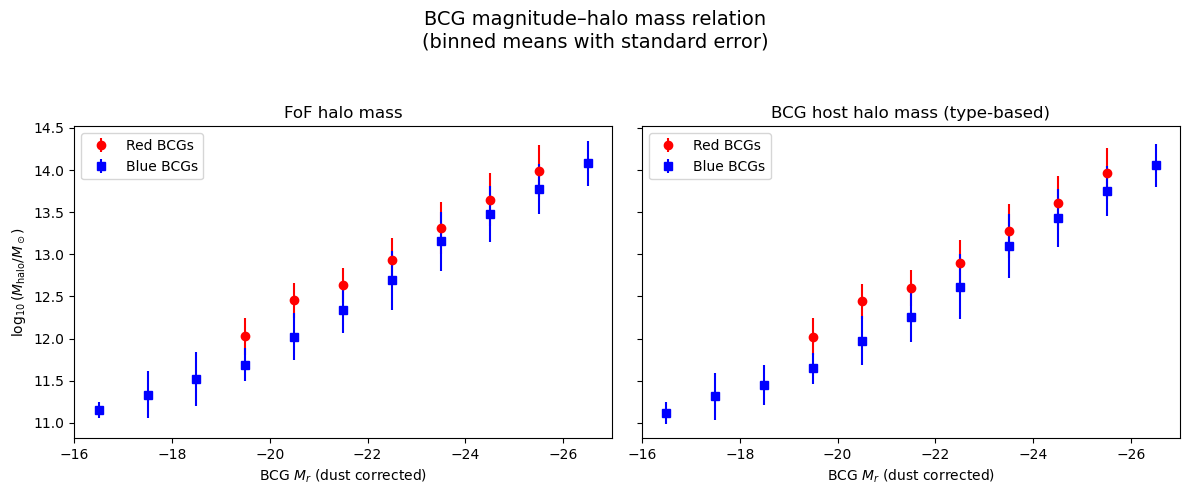

In [22]:
# -----------------------------
# Columns / definitions
# -----------------------------
group_col = "id_fof"
mag_col   = "total_ab_dust_r_VST"
fof_mass_col = "fof_halo_mass"
host_mass_col = "mvir_hosthalo"
type_col  = "type"

# red / blue split
gals["is_red"] = gals["log_sSFR"] < -11

# -----------------------------
# Build BCG table (type = 0,2; brightest in r)
# -----------------------------
ungrouped = gals[group_col] == -1
is_central_type = gals[type_col].isin([0, 2])

valid = (
    (~ungrouped) &
    is_central_type &
    gals[mag_col].notna()
)

bcg_idx = gals.loc[valid].groupby(group_col)[mag_col].idxmin()
bcg = gals.loc[bcg_idx].copy()

# -----------------------------
# Add halo masses
# -----------------------------
# FoF halo mass (already computed earlier)
bcg["fof_halo_mass"] = bcg[fof_mass_col]

# Host halo mass (for the BCG itself)
bcg["host_halo_mass"] = bcg[host_mass_col]

# -----------------------------
# Magnitude bins (width = 1 mag)
# -----------------------------
mag_min = np.floor(bcg[mag_col].min())
mag_max = np.ceil(bcg[mag_col].max())
mag_bins = np.arange(mag_min, mag_max + 1, 1.0)
mag_centres = 0.5 * (mag_bins[:-1] + mag_bins[1:])

# -----------------------------
# Helper: binned mean + error
# -----------------------------
def binned_mean_and_err(x, y, bins):
    mean = np.full(len(bins) - 1, np.nan)
    err  = np.full(len(bins) - 1, np.nan)

    for i, (b0, b1) in enumerate(zip(bins[:-1], bins[1:])):
        sel = (x >= b0) & (x < b1)
        if sel.sum() > 1:
            mean[i] = np.mean(y[sel])
            err[i]  = np.std(y[sel], ddof=1)

    return mean, err

# -----------------------------
# Panel A: FoF halo mass
# -----------------------------
y_fof = np.log10(bcg["fof_halo_mass"].where(bcg["fof_halo_mass"] > 0))
x = bcg[mag_col]

mean_red_fof, err_red_fof = binned_mean_and_err(
    x[bcg["is_red"]], y_fof[bcg["is_red"]], mag_bins
)
mean_blue_fof, err_blue_fof = binned_mean_and_err(
    x[~bcg["is_red"]], y_fof[~bcg["is_red"]], mag_bins
)

# -----------------------------
# Panel B: host halo mass (type-based)
# -----------------------------
y_host = np.log10(bcg["host_halo_mass"].where(bcg["host_halo_mass"] > 0))

mean_red_host, err_red_host = binned_mean_and_err(
    x[bcg["is_red"]], y_host[bcg["is_red"]], mag_bins
)
mean_blue_host, err_blue_host = binned_mean_and_err(
    x[~bcg["is_red"]], y_host[~bcg["is_red"]], mag_bins
)

# -----------------------------
# Plot
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Panel A ---
axes[0].errorbar(
    mag_centres, mean_red_fof, yerr=err_red_fof,
    fmt="o", color="r", label="Red BCGs"
)
axes[0].errorbar(
    mag_centres, mean_blue_fof, yerr=err_blue_fof,
    fmt="s", color="b", label="Blue BCGs"
)

axes[0].set_title("FoF halo mass")
axes[0].set_xlabel(r"BCG $M_r$ (dust corrected)")
axes[0].set_ylabel(r"$\log_{10}(M_{\rm halo}/M_\odot)$")
axes[0].legend(frameon=True)
axes[0].invert_xaxis()

# --- Panel B ---
axes[1].errorbar(
    mag_centres, mean_red_host, yerr=err_red_host,
    fmt="o", color="r", label="Red BCGs"
)
axes[1].errorbar(
    mag_centres, mean_blue_host, yerr=err_blue_host,
    fmt="s", color="b", label="Blue BCGs"
)

axes[1].set_title("BCG host halo mass (type-based)")
axes[1].set_xlabel(r"BCG $M_r$ (dust corrected)")
axes[1].legend(frameon=True)
axes[1].invert_xaxis()

fig.suptitle(
    "BCG magnitude–halo mass relation\n(binned means with standard error)",
    fontsize=14,
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
